**Redes Neurais/Auto-Encoders - Prof. Dr. Luis F. Alves Pereira**

---
**Conteúdo:**

* Download da base
* Visualização das imagens
* Contrução do modelo
* Treinamento do modelo
* Visualização dos resultados
---


#1. Download da base

Inicialmente, vamos baixar a base FashionMNIST que, por sua simplicidade, pode ser muito útil para validar conceitos.



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVKN6PO/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVKN6PO/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


#2. Visualização dos dados

Com o código a seguir, vemos que cada batch de dados contém $128$ representações de itens de moda com tamanho $28\times28$ cada. Os $64$ primeiros exemplos do batch inicial são apresentados a seguir:

Entradas
Dimensão do batch:  (128, 28, 28, 1)


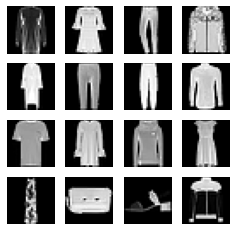

Saidas
Dimensão do batch:  (128, 28, 28, 1)


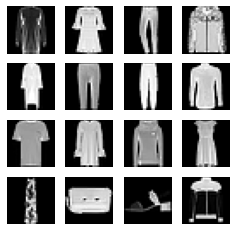

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def plot_grid_sample(size, data):
  fig = plt.gcf()
  fig.set_size_inches(size, size)
  cont = 1
  w = 4
  for ii in range(size):
    for jj in range(size):
        sp = plt.subplot(size, size, cont)
        sp.axis('Off')
        plt.imshow((np.squeeze(data[cont,:,:,:])), cmap='gray')
        cont+=1
  plt.show()

X, Y = next(iter(train_dataset))
print("Entradas")
print("Dimensão do batch: ", X.shape)
plot_grid_sample(4,X)
print("Saidas")
print("Dimensão do batch: ", Y.shape)
plot_grid_sample(4,Y)


#3. Construção do modelo

Agora, vamos nos concentrar na construção do modelo que segue:

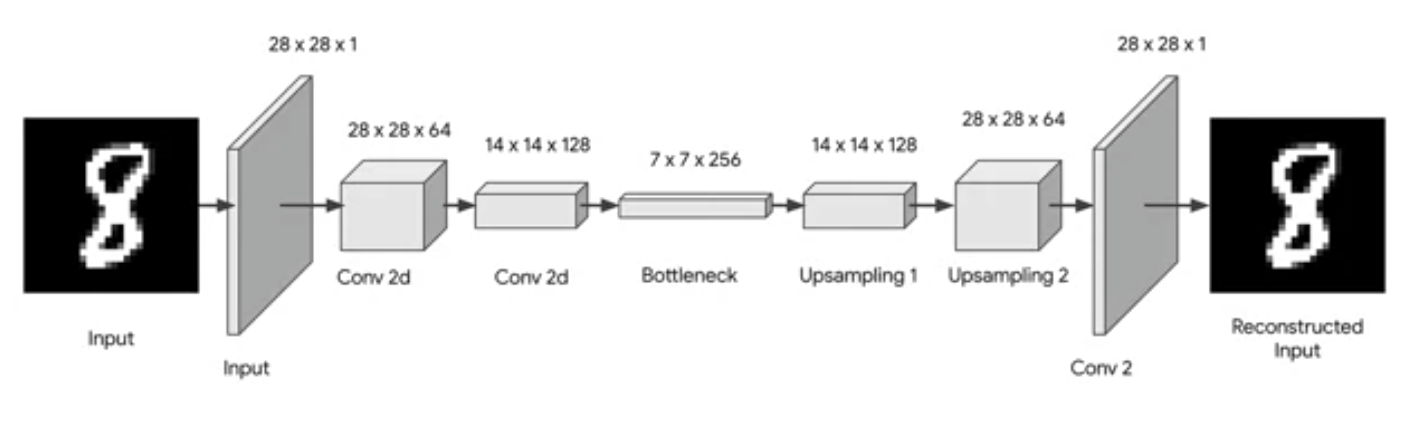

O código para as três partes do Auto-Encoder da figura (i.e., enconding, bottleneck, decoding) são dados separadamente pelas três funções que seguem:

In [ ]:
#codigo sugerido pelo DeepLearningAI

def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

Agora, uma função para retornar o modelo completo:

In [ ]:
#codigo sugerido pelo DeepLearningAI

def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

#4. Treinamento do modelo

Uma vez com os dados e o modelo, iniciamos o treinamento:

In [ ]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
468/468 [==============================] - 39s 59ms/step - loss: 0.2904 - val_loss: 0.2675
Epoch 2/40
468/468 [==============================] - 25s 52ms/step - loss: 0.2607 - val_loss: 0.2603
Epoch 3/40
468/468 [==============================] - 24s 52ms/step - loss: 0.2558 - val_loss: 0.2559
Epoch 4/40
468/468 [==============================] - 24s 52ms/step - loss: 0.2532 - val_loss: 0.2544
Epoch 5/40
468/468 [==============================] - 24s 52ms/step - loss: 0.2518 - val_loss: 0.2531
Epoch 6/40
468/468 [==============================] - 24s 52ms/step - loss: 0.2507 - val_loss: 0.2525
Epoch 7/40
468/468 [==============================] - 24s 52ms/step - loss: 0.2498 - val_loss: 0.2514
Epoch 8/40
468/468 [==============================] - 24s 51ms/step - loss: 0.2492 - val_loss: 0.2509
Epoch 9/40
468/468 [==============================] - 24s 51ms/step - loss: 0.2487 - val_loss: 0.2503
Epoch 10/40
468/468 [==============================] - 24s 51ms/step - loss: 0.248

#5. Visualização dos resultados

In [ ]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

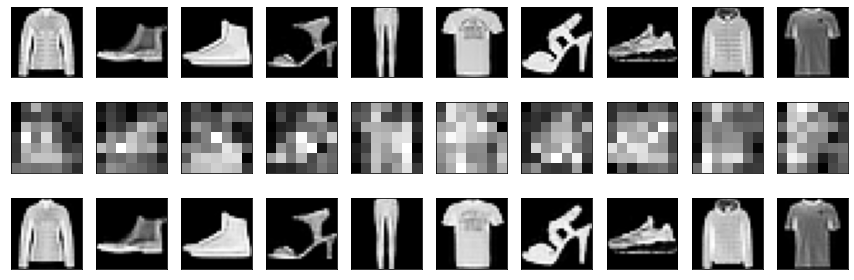

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))